# Détection d'e-mails de phishing par classification supervisée

Les données utilisées dans ce projet proviennent de l'URL suivant : https://www.kaggle.com/datasets/subhajournal/phishingemails. Elles concernent des corps de mails étiquettés comme "safe" ou "phishing".

In [1]:
#Zones d'importation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder

In [2]:
#Chargement du dataset

df = pd.read_csv("Phishing_Email.csv")

#Nettoyage des valeurs Nan

df.dropna(inplace=True)

In [3]:
#Visualisation du contenu

df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
#Suppression de la première colonne inutile

df = df.iloc[:, 1:]
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


Nous choisissons la vectorisation TF-IDF, afin de transformer le texte brut des e-mails en vecteurs à valeurs pondérées qui mettent en avant les termes les plus importants d’un mail par rapport à l’ensemble du corps de texte. Elle va alors nous permettre de mieux capturer les mots différenciant les mails de phishing et légitimes.

In [5]:
#Initialisation du vectoriseur TF-IDF

vectoriseur = TfidfVectorizer(stop_words='english', max_features=5000)

#Transformation du texte en vecteurs TF-IDF

X = vectoriseur.fit_transform(df['Email Text'])

#Initialisation de la variable cible (type de mail)

y = df['Email Type']
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [6]:
#Vérification de l'équilibre des classes

y.value_counts()

Safe Email        11322
Phishing Email     7312
Name: Email Type, dtype: int64

Notre dataset présente un déséquilibre modéré entre les types de mail (environ 60%/40%). Ce niveau de déséquilibre reste acceptable pour une classification binaire, d’autant plus que des métriques comme le F1-score et l'AUC (ROC et PR) sont utilisées pour évaluer les performances des modèles de manière équilibrée.

In [7]:
#Séparation en train/test sets (80%/20%)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

Dans ce projet, plusieurs modèles de classification ont été choisis en raison de leurs performances éprouvées et de leur capacité à traiter des datasets textuels :

- Logistic Regression :

Modèle simple et interprétable, la régression logistique est efficace dans des problèmes de classification binaire, comme le notre.

- Random Forest :

Modèle d'ensemble combinant plusieurs arbres de décision et dont la robustesse permet de réduire le surapprentissage.

- Naive Bayes :

Modèle probabiliste efficace pour les tâches de classification sur des données textuelles comme la notre.

- Support Vector Machine (SVM) :

Modèle très puissant choisi ici en raison de son efficacité dans la classification binaire, en particulier dans des cas de données déséquilibrées.

In [8]:
#Dictionnaire des modèles avec leurs grilles de paramètres à optimiser

models_params = {
    
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'C': np.logspace(-4, 3, 10),
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs']}},
    
    "SVC": {
        "model": SVC(),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}},
    
    "MultinomialNB": {
        "model": MultinomialNB(),
        "params": {
            'alpha': [0.01, 0.1, 1.0, 10],
            'fit_prior': [True, False]}},
    
    "RandomForestClassifier": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']}}
    
}

Afin d'optimiser la performance des modèles choisis, nous allons utiliser le GridSearchCV pour déterminer les hyperparamètres qui maximisent leurs performances. Nous ensuite les modèles optimaux pour selctionner celui d'entre eux qui prédit le mieux la nature des mails.

In [9]:
#Dictionnaire pour stocker les modèles optimisés

meilleurs_modeles = {}
resultats_cv = {}

#Boucle sur chaque modèle

for nom, modele in models_params.items():
    print(f"Optimisation de {nom}...")

    #GridSearch pour hyperparamètres
    debut = time.time()
    grid = GridSearchCV(modele["model"], modele["params"], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    temps = time.time()-debut
    
    #Meilleur modèle
    best_model = grid.best_estimator_
    meilleurs_modeles[nom] = best_model
    
    print(f"Meilleurs paramètres : {grid.best_params_}")
    
    #Évaluation via cross_val_score
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    std_score = scores.std()
    resultats_cv[nom] = (mean_score, std_score)

    print(f"F1 moyenne : {mean_score:.4f} ± {std_score:.4f}")
    if temps < 60 :
        print(f"Temps d'entraînement : {int(temps)} secondes.\n")
    else :
        print(f"Temps d'entraînement : {int(temps//60)} minutes et {int(temps - (temps//60)*60)} secondes.\n")

Optimisation de LogisticRegression...
Meilleurs paramètres : {'C': 4.641588833612782, 'penalty': 'l2', 'solver': 'liblinear'}
F1 moyenne : 0.9735 ± 0.0021
Temps d'entraînement : 5 secondes.

Optimisation de SVC...
Meilleurs paramètres : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
F1 moyenne : 0.9754 ± 0.0023
Temps d'entraînement : 9 minutes et 54 secondes.

Optimisation de MultinomialNB...
Meilleurs paramètres : {'alpha': 0.1, 'fit_prior': False}
F1 moyenne : 0.9657 ± 0.0020
Temps d'entraînement : 1 secondes.

Optimisation de RandomForestClassifier...
Meilleurs paramètres : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
F1 moyenne : 0.9713 ± 0.0025
Temps d'entraînement : 2 minutes et 46 secondes.



Après optimisation des hyperparamètres avec GridSearchCV, les modèles ont été évalués via validation croisée : les meilleurs modèles, Logistic Regression, Random Forest et SVM, obtiennent des scores F1 moyens supérieurs à 0.97. Le modèle Multinomial Naive Bayes semble légèrement moins performante, mais restent compétitif. Nos modèles semblent dans l'ensemble tous relativement stables avec une faible variance relevée. Regardons l'aire sous les courbes (AUC) ROC et PR, afin de confirmer nos intuitions et prouver la bonne capacité de nos modèles à distinguer les classes malgré un léger déséquilibre.

In [10]:
print("Aire sous la courbe (AUC) :")
for nom, modele in meilleurs_modeles.items():
    y_proba = modele.predict_proba(X_test)[:, 1] if hasattr(modele, "predict_proba") else modele.decision_function(X_test)
    
    auc_roc = roc_auc_score(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)
    
    print(f"{nom:<23} | ROC: {auc_roc:.3f} | PR: {auc_pr:.3f}")

Aire sous la courbe (AUC) :
LogisticRegression      | ROC: 0.998 | PR: 0.998
SVC                     | ROC: 0.993 | PR: 0.996
MultinomialNB           | ROC: 0.994 | PR: 0.996
RandomForestClassifier  | ROC: 0.995 | PR: 0.997


Les F1-scores de nos modèles sont dans l'ensemble très élevés et suggèrent que nos modèles prédisent très bien la nature d'un mail grâce à leur contenu. Aussi, les AUC sont également très proches de 1 pour tous les modèles, ce qui confirme leur excellente capacité à discriminer entre les mails de phishing et les mails légitimes, malgré le léger déséquilibre de classes. En revanche, cette analyse ne nous permet pas pour le moment de sélectionner précisément un modèle aux dépens d'un autre...

Pour y parevenir, nous allons nous concentrer sur les matrices de confusion : elles nous permettent d'examiner la nature des erreurs commises par chaque modèle (faux positifs et faux négatifs), afin d'aider à la prise de décision en fonction des priorités du problème (minimiser certains types d'erreurs).

In [11]:
#Dictionnaire pour stocker les matrices

matrices_confusion = {}

#Boucle sur chaque modèle

for nom, modele in meilleurs_modeles.items():
    
    y_pred = modele.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    matrices_confusion[nom] = cm
    
    print(f"Matrice de confusion pour {nom} :\n{cm}")

Matrice de confusion pour LogisticRegression :
[[1435   27]
 [  65 2200]]
Matrice de confusion pour SVC :
[[1436   26]
 [  55 2210]]
Matrice de confusion pour MultinomialNB :
[[1425   37]
 [  97 2168]]
Matrice de confusion pour RandomForestClassifier :
[[1416   46]
 [  62 2203]]


Globalement, à contraintes équivalentes, un modèle qui parvient à minimiser à la fois les faux positifs et les faux négatifs sera naturellement privilégié. En revanche, lorsque certains modèles excellent dans la réduction d’un type d’erreur au détriment de l’autre, le choix du modèle dépendra alors des préférences du décideur, et notamment de son niveau de tolérance ou d’aversion vis-à-vis de chaque type d’erreur.

Le modèle SVC est celui qui minimise les erreurs "faux positif" et "faux négatif", voici sa confusion matrix :


<Figure size 600x400 with 0 Axes>

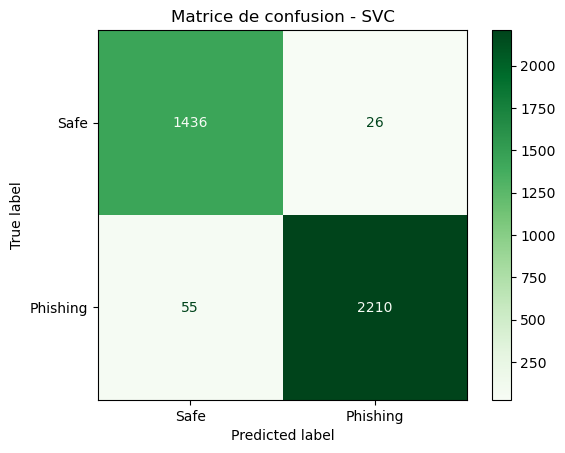

In [12]:
minfp, matfp = len(df), np.zeros((2,2))
minfn, matfn = len(df), np.zeros((2,2))

for c in matrices_confusion.values():
    if c[0][1] < minfp :
        minfp = c[0][1]
        matfp = c
    if c[1][0] < minfn :
        minfn = c[1][0]
        matfn = c

if np.array_equal(matfp, matfn) :
    for modele, cm in matrices_confusion.items():
        if np.array_equal(cm, matfp):
            mod = modele
    print(f'Le modèle {mod} est celui qui minimise les erreurs "faux positif" et "faux négatif", voici sa confusion matrix :')
    disp = ConfusionMatrixDisplay(confusion_matrix=matfn, display_labels=["Safe", "Phishing"])
    plt.figure(figsize=(6, 4))
    disp.plot(cmap="Greens", values_format='d')
    plt.title(f"Matrice de confusion - {mod}")
    plt.grid(False)
    plt.show()
else:
    print("Aucun modèle ne minimise les deux types d'erreur, un arbitrage sur l'importance donnée à chaque type d'erreur s'impose.")

Bien que le modèle SVC offre d’excellents résultats en minimisant les deux types d’erreurs, son usage peut être limité par des considérations pratiques. Nous avons en effet vu que son temps d'entraînement est 6 à près de 400 fois plus important que celui des autres modèles (6 minutes contre 1 seconde à 1 minute pour les autres). Il est donc intéressant d’évaluer les performances des autres modèles dans ce contexte. 

In [13]:
#On supprime SVC

del matrices_confusion["SVC"]

À ce stade, après exclusion du modèle SVC pour des raisons pratiques, aucun des modèles restants ne parvient à minimiser simultanément les deux types d’erreurs, et donc chaque modèle présente un compromis différent.
Pour guider la prise de décision dans ce contexte, nous introduisons une fonction de préférence qui pondère l’importance relative des faux négatifs et des faux positifs. Ce critère, paramétré par un poids $p \in [0, 1]$, permet de sélectionner le modèle le plus adapté aux priorités opérationnelles du décideur.

Par exemple, un administrateur système qui se soucie de la sécurité pourrait préférer minimiser les faux négatifs ($p>0.5$), c’est-à-dire éviter de laisser passer un email de phishing, quitte à classer à tort quelques emails légitimes comme suspects. À l’inverse, un service client pourrait chercher à minimiser les faux positifs ($p<0.5$) afin d’éviter de bloquer inutilement des communications valides avec les utilisateurs. Enfin, un décideur neutre ou sans préférence pourrait simplement vouloir minimiser le nombre total d’erreurs ($p=0.5$), en équilibrant les deux types d’erreurs de manière équitable.

Le décideur cherchera alors à minimser sa fonction de coût relativement au nombres d'erreurs selon leur type (FP : Faux Positifs, pondéré par $1-p$ et FN : Faux Négatifs, pondéré par $p$). Dans le cas d'une fonction de coût linéaire, on peut ainsi définir $ f_p(FN,FP) = p \times FN + (1-p) \times FP $. Cette fonction est ensuite évaluée pour chaque modèle afin d’identifier celui qui minimise le coût global selon les préférences du décideur.

In [14]:
def fc(matrices_confusion, p):
    if 0 <= p <= 1: 
        meilleur_modele = None
        meilleure_cm = None
        score_min = float('inf')

        for nom, cm in matrices_confusion.items():
            fp = cm[0, 1]  #Faux positifs
            fn = cm[1, 0]  #Faux négatifs
            score = p * fn + (1 - p) * fp #Coût

            if score < score_min:
                score_min = score
                meilleur_modele = nom
                meilleure_cm = cm

        print(f"Meilleur modèle pour p={p}: {meilleur_modele}")
        disp = ConfusionMatrixDisplay(confusion_matrix=meilleure_cm, display_labels=["Safe", "Phishing"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Greens", values_format='d')
        plt.title(f"Matrice de confusion - {meilleur_modele}")
        plt.grid(False)
        plt.show()

        return meilleur_modele

Meilleur modèle pour p=0.95: RandomForestClassifier


<Figure size 600x400 with 0 Axes>

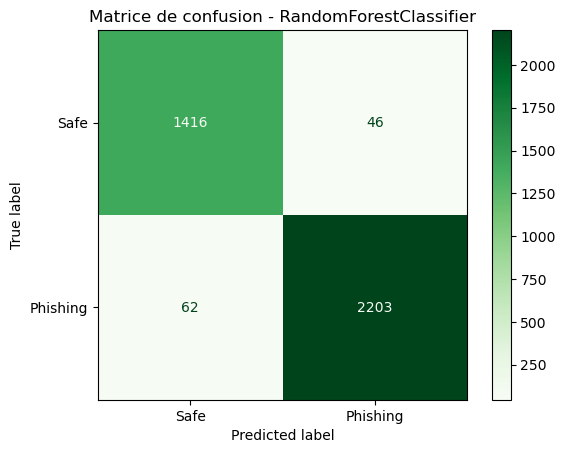

'RandomForestClassifier'

In [15]:
fc(matrices_confusion, p=0.95)

Dans le cas d'une forte aversion pour le risque de non-détection (prédire un mail de phishing comme safe), avec $p > 0.5$, le modèle de Random Forest Classifier est préféré. C'est en effet celui-ci qui minimse ce type d'erreur.

Meilleur modèle pour p=0.5: LogisticRegression


<Figure size 600x400 with 0 Axes>

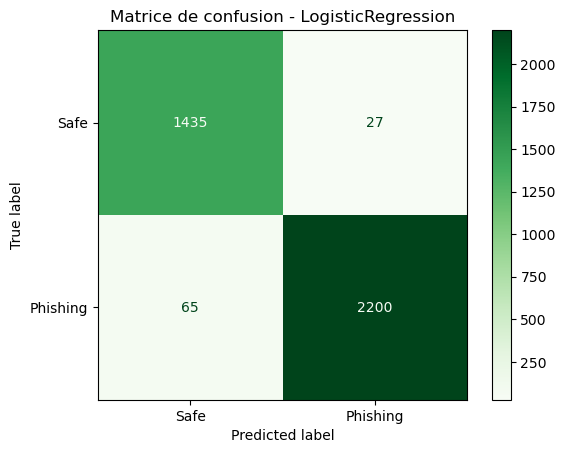

'LogisticRegression'

In [16]:
fc(matrices_confusion, p=0.5)

En revanche, un décideur indifférent vis à vis du type d'erreur privilégiée, avec $ p = 0.5 $, va préférer un modèle de Régression Logistique, modèle qui totalise le moins d'erreurs :

In [17]:
for nom, cm in matrices_confusion.items() :
    erreurs = cm[0,1] + cm[1,0]
    print(f"Nombre d'erreurs pour {nom} : {erreurs}")

Nombre d'erreurs pour LogisticRegression : 92
Nombre d'erreurs pour MultinomialNB : 134
Nombre d'erreurs pour RandomForestClassifier : 108


Meilleur modèle pour p=0.05: LogisticRegression


<Figure size 600x400 with 0 Axes>

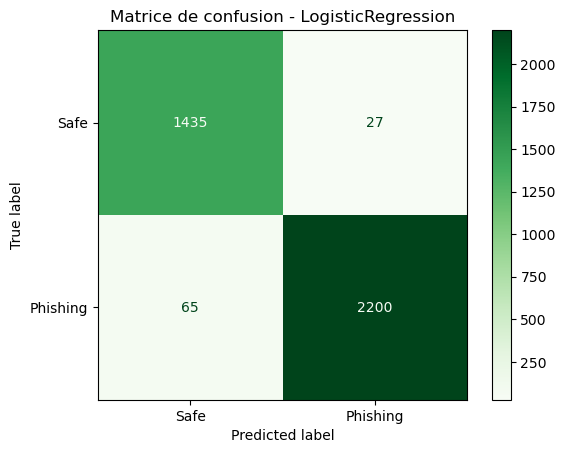

'LogisticRegression'

In [18]:
fc(matrices_confusion, p=0.05)

Enfin, pour une forte aversion pour le risque de fausse alerte (prédire un mail safe comme étant un mail de phishing), avec $p < 0.5$, le modèle de Régression Logistique est encore préféré.

Il pourrait alors être intéressant de tracer, pour chaque modèle et selon l'évolution du paramètre $p$, la courbe de la fonction de coût afin de faciliter la prise de décision.

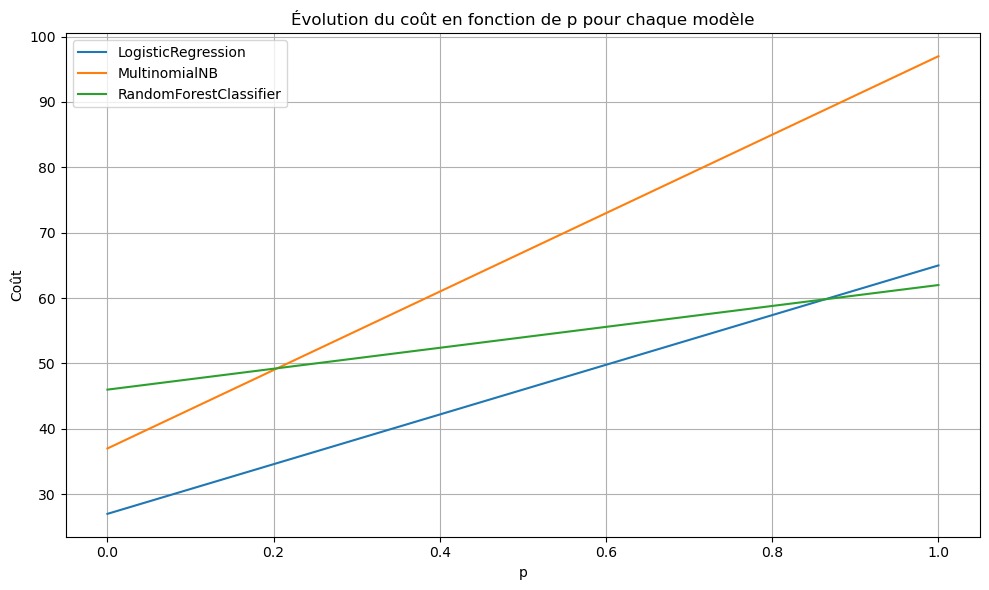

In [19]:
val_p = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))

for nom, cm in matrices_confusion.items():
    fn = cm[1][0]
    fp = cm[0][1]
    scores = [p * fn + (1 - p) * fp for p in val_p]
    plt.plot(val_p, scores, label=nom)

plt.xlabel("p")
plt.ylabel("Coût")
plt.title("Évolution du coût en fonction de p pour chaque modèle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le modèle MultinomialNB semble ne jamais être optimal : à contraintes équivalentes, le modèle de Régression Logistique lui sera toujours préféré : il minimise en effet chaque erreur par rapport à ce dernier et donc la fonction de coût associée. Nous allons donc nous en séparer pour finaliser notre analyse.

In [20]:
#On supprime MultinomialNB

del matrices_confusion["MultinomialNB"]

In [21]:
#Initialisation des variables contenant les confusion matrix de nos deux modèles

cmlr = list(matrices_confusion.values())[0] #Matrice du modèle de Régression Logistique
cmrfc = list(matrices_confusion.values())[1] #Matrice du modèle Random Forest

Il ne nous reste désormais plus que 2 modèles à analyser : Régression Logistique et Random Forest. Nous allons déterminer la valeur de $p$ qui rend un décideur indifférent entre choisir un modèle plutôt que l'autre. Pour cela, nous allons résoudre en $p$ l'équation : 

$$
FN_{\text{LogisticRegression}} \times p + FP_{\text{LogisticRegression}} \times (1-p) = FN_{\text{RandomForest}} \times p + FP_{\text{RandomForest}} \times (1-p)
$$

Cette équation est équivalente à :

$$
p = \frac{FP_{\text{RF}} - FP_{\text{LR}}}{(FN_{\text{LR}} - FP_{\text{LR}}) - (FN_{\text{RF}} - FP_{\text{RF}})}
$$

In [22]:
p = (cmrfc[0][1] - cmlr[0][1])/((cmlr[1][0] - cmlr[0][1]) - (cmrfc[1][0] - cmrfc[0][1]))

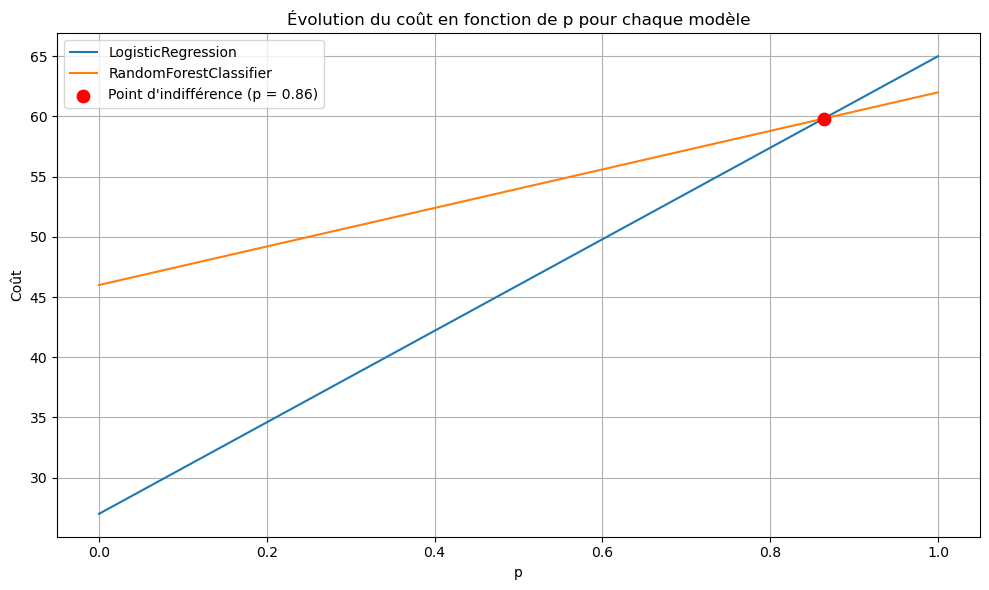

In [23]:
val_p = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))

for nom, cm in matrices_confusion.items():
    fn = cm[1][0]
    fp = cm[0][1]
    scores = [p * fn + (1 - p) * fp for p in val_p]
    plt.plot(val_p, scores, label=nom)

plt.scatter(p, p * fn + (1 - p) * fp, c='r', s=80, zorder=5, label=f"Point d'indifférence (p = {round(p,2)})")
plt.xlabel("p")
plt.ylabel("Coût")
plt.title("Évolution du coût en fonction de p pour chaque modèle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Notre représentation graphique met en lumière que dans notre cas, seul un décideur très averse au risque de non détection ($ p > 0.86 $) va préférer utiliser le modèle de Random Forest à celui de Régression Logistique. D'autres décideurs moins averses à ce risque préféreront le modèle de Régression Logistique ($ p < 0.86 $) ou seront indifférents entre choisir l'un ou l'autre ($ p = 0.86 $).

Pour ce modèle, il est pertinent de s’interroger sur les mots ayant la plus grande influence sur la prédiction de la nature d’un mail, que nous mettrons ensuite à l'épreuve sur des mails personnellement reçus : un mail de phishing et un mail légitime.

In [24]:
lr = meilleurs_modeles['LogisticRegression']

In [25]:
#Verification de quel label correspond à quelle classe

print(le.classes_)
print(lr.classes_)

['Phishing Email' 'Safe Email']
[0 1]


In [26]:
#Récupération des mots et coefficients associés

coefficients = lr.coef_[0]
mots = vectoriseur.get_feature_names_out()

#Mots associés au phishing (coefficients négatifs)

top_phishing = sorted(zip(coefficients, mots))[:10]

#Mots associés aux mails sûrs (coefficients positifs)

top_safe = sorted(zip(coefficients, mots), reverse=True)[:10]

print("Top 10 des mots associés au Phishing :")
print(pd.DataFrame(top_phishing, columns=["Coefficient", "Mot"]))

print("\nTop 10 des mots associés aux Safe Emails :")
print(pd.DataFrame(top_safe, columns=["Coefficient", "Mot"]))

Top 10 des mots associés au Phishing :
   Coefficient        Mot
0    -7.340211       2005
1    -6.821041  sightings
2    -5.668773     remove
3    -5.352274       2004
4    -5.001971      money
5    -4.958564       site
6    -4.794825      click
7    -4.244875    removed
8    -4.157453      email
9    -4.083382        low

Top 10 des mots associés aux Safe Emails :
   Coefficient         Mot
0    11.241882       enron
1     8.109236         url
2     7.846094       wrote
3     6.961509        2002
4     6.754695      thanks
5     6.507487    language
6     5.932066  university
7     5.559034         edu
8     5.460248       vince
9     5.229014      louise


In [27]:
#Mails personnels

email_phishing = ["It’s Cinco de Mayo — time to party! Celebrate by growing your Instagram with a huge 35% OFF our real IG followers, likes, and views.Use code CINCO35 at checkout. Hurry, fiesta ends tonight!"]
email_safe = ["An intervention by the residence’s Internet service provider will take place next week, on Monday, May 5th, 2025, starting at 10 a.m. Please ensure the technician has access. The intervention will be brief and will help improve the building’s Wi-Fi connection. Please read the attached document. For any further information, we remain at your disposal. Best regards, Imane"]

#Transformer le texte en vecteurs TF-IDF (en utilisant le même vectoriseur déjà entraîné)

X_email_phishing = vectoriseur.transform(email_phishing)
X_email_safe = vectoriseur.transform(email_safe)

#Prédictions

prediction_phishing = lr.predict(X_email_phishing)
prediction_safe = lr.predict(X_email_safe)

#Affichage

pred_label_phishing = le.inverse_transform(prediction_phishing)[0]
print(f"Le mail de phishing est classé comme {pred_label_phishing}")
pred_label_safe = le.inverse_transform(prediction_safe)[0]
print(f"Le mail safe est classé comme {pred_label_safe}")

Le mail de phishing est classé comme Phishing Email
Le mail safe est classé comme Safe Email
